http://blog.varunajayasiri.com/numpy_lstm.html

# Imports

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

# Read and process data

In [2]:
data = open('shakespear.txt', 'r').read()

In [3]:
chars = list(set(data)) # unique chars
data_size, X_size = len(data), len(chars)
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

# Parameters

In [4]:
H_size = 100 # size of hidden layer
T_steps = 25 # number of time steps (length of sequence) used for training
learning_rate = 1e-1 # learning rate
weight_sd = 0.1 # standard deviation of weights for initialization
z_size = H_size + X_size # size of concatenate (H,X) vector

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def dsigmoid(y):
    return y*(1-y)
def tanh(x):
    return np.tanh(x)
def dtanh(y):
    return 1 - y*y

# Initialize weights

We use random weights with normal distribution(0,weight_sd) for tanh activation function and (0.5,weight_sd) for sigmoid activation function. Biases are initialized to zeroes.

In [6]:
W_f = np.random.randn(H_size, z_size) * weight_sd + 0.5
b_f = np.zeros((H_size, 1))

W_i = np.random.randn(H_size, z_size) * weight_sd + 0.5
b_i = np.zeros((H_size, 1))

W_C = np.random.randn(H_size, z_size) * weight_sd
b_C = np.zeros((H_size, 1))

W_o = np.random.randn(H_size, z_size) * weight_sd + 0.5
b_o = np.zeros((H_size, 1))

In [7]:
# For final layer to predict the next character
W_y = np.random.randn(X_size, H_size) * weight_sd
b_y = np.zeros((X_size, 1))

# Gradients

In [8]:
dW_f = np.zeros_like(W_f)
dW_i = np.zeros_like(W_i)
dW_C = np.zeros_like(W_C)

dW_o = np.zeros_like(W_o)
dW_y = np.zeros_like(W_y)

db_f = np.zeros_like(b_f)
db_i = np.zeros_like(b_i)
db_C = np.zeros_like(b_C)

db_o = np.zeros_like(b_o)
db_y = np.zeros_like(b_y)

# Forward pass

In [9]:
def forward(x, h_prev, C_prev):
    assert x.shape == (X_size,1)
    assert h_prev.shape == (H_size,1)
    assert C_prev.shape == (H_size,1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(W_f,z) + b_f)
    i = sigmoid(np.dot(W_i,z) + b_i)
    C_bar = tanh(np.dot(W_C, z) + b_C)
    
    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(W_o, z) + b_o)
    h = o*tanh(C)
    
    y = np.dot(W_y, h) + b_y
    p = np.exp(y) / np.sum(np.exp(y))
    
    return z, f, i, C_bar, C, o, h, y, p

# Backward pass

In [10]:
def backward(target, dh_next, dC_next, C_prev, z, f, i, C_bar, C, o, h, y, p):

    global dW_f, dW_i, dW_C, dW_o, dW_y
    global db_f, db_i, db_C, db_o, db_y

    assert z.shape == (X_size + H_size, 1)
    assert y.shape == (X_size, 1)
    assert p.shape == (X_size, 1)

    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)

    dy = np.copy(p)
    dy[target] -= 1

    dW_y += np.dot(dy, h.T)
    db_y += dy

    dh = np.dot(W_y.T, dy)
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    dW_o += np.dot(do, z.T)
    db_o += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dC_bar * dtanh(C_bar)
    dW_C += np.dot(dC_bar, z.T)
    db_C += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    dW_i += np.dot(di, z.T)
    db_i += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    dW_f += np.dot(df, z.T)
    db_f += df

    dz = np.dot(W_f.T, df) \
        + np.dot(W_i.T, di) \
        + np.dot(W_C.T, dC_bar) \
        + np.dot(W_o.T, do)
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC

    return dh_prev, dC_prev

# Forward Backward Pass

In [11]:
def forward_backward(inputs, targets, h_prev, C_prev):
    # To store the values for each time step
    x_s, z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s, y_s, p_s = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)

    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character

        z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t], y_s[t], p_s[t] \
            = forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass

        loss += -np.log(p_s[t][targets[t], 0]) # Loss for at t


    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        dparam.fill(0)

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = backward(target = targets[t], dh_next = dh_next, dC_next = dC_next, C_prev = C_s[t-1],
                 z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t], C = C_s[t], o = o_s[t],
                 h = h_s[t], y = y_s[t], p = p_s[t])

    # Clip gradients to mitigate exploding gradients
    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        np.clip(dparam, -1, 1, out=dparam)

    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

# Sample the next character

In [12]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []

    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

# Training (Adagrad)

In [13]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss

    # Get predictions for 200 letters with current model
    display.clear_output(wait=True)

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.display(plt.gcf())

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [14]:
mW_f = np.zeros_like(W_f)
mW_i = np.zeros_like(W_i)
mW_C = np.zeros_like(W_C)
mW_o = np.zeros_like(W_o)
mW_y = np.zeros_like(W_y)

mb_f = np.zeros_like(b_f)
mb_i = np.zeros_like(b_i)
mb_C = np.zeros_like(b_C)
mb_o = np.zeros_like(b_o)
mb_y = np.zeros_like(b_y)

In [15]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, p = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

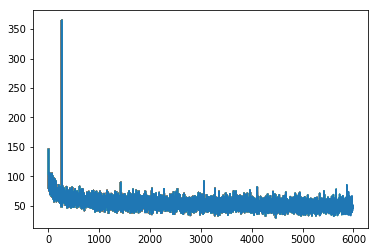

----
 d?

FALAGGLS:
But slaths, by, be, in gocc dellith apraty, your pelllon's know, dome cally speegeghs, beard her.

PUCKIT:
Oe as blike, viliin?

NA ALTIOT:
Bfan do your treas for theie I houle, and asmy 
----
iter 5989, loss 49.441189


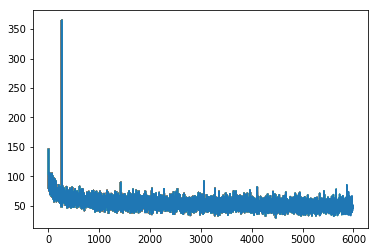

In [16]:
while True:
    # Try catch for interruption
    try:
        # Reset
        if p + T_steps >= len(data) or iteration == 0:
            g_h_prev = np.zeros((H_size, 1))
            g_C_prev = np.zeros((H_size, 1))
            p = 0


        inputs = [char_to_idx[ch] for ch in data[p: p + T_steps]]
        targets = [char_to_idx[ch] for ch in data[p + 1: p + T_steps + 1]]

        loss, g_h_prev, g_C_prev =  forward_backward(inputs, targets, g_h_prev, g_C_prev)
        smooth_loss = smooth_loss * 0.999 + loss * 0.001

        # Print every hundred steps
        if iteration % 100 == 0:
            update_status(inputs, g_h_prev, g_C_prev)


        # Update weights
        for param, dparam, mem in zip([W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y],
                                      [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y],
                                      [mW_f, mW_i, mW_C, mW_o, mW_y, mb_f, mb_i, mb_C, mb_o, mb_y]):
            mem += dparam * dparam # Calculate sum of gradients
            #print(learning_rate * dparam)
            param += -(learning_rate * dparam / np.sqrt(mem + 1e-8))

        plot_iter = np.append(plot_iter, [iteration])
        plot_loss = np.append(plot_loss, [loss])

        p += T_steps
        iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

# Gradient check

In [17]:
from random import uniform

In [18]:
def gradient_check(inputs, target, h_prev, C_prev):
    global W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y
    global dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y

    num_checks = 10 # Number of parameters to test
    delta = 1e-5 # The change to make on the parameter

    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)

    for param, dparam, name in zip([W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y],
                                 [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y],
                                 ['W_f', 'W_i', 'W_C', 'W_o', 'W_y', 'b_f', 'b_i', 'b_C', 'b_o', 'b_y']):
        assert param.shape == dparam.shape
        dparam_copy = np.copy(dparam) #Make a copy because this will get modified

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0,param.size))

            # evaluate cost at [x + delta] and [x - delta]
            old_val = param.flat[rnd_idx]
            param.flat[rnd_idx] = old_val + delta
            loss_plus_delta, _, _ = forward_backward(inputs, targets, h_prev, C_prev)
            param.flat[rnd_idx] = old_val - delta
            loss_mins_delta, _, _ = forward_backward(inputs, targets, h_prev, C_prev)
            param.flat[rnd_idx] = old_val

            grad_analytical = dparam_copy.flat[rnd_idx]
            grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
            # Clip numerical error because grad_analytical is clipped
            [grad_numerical] = np.clip([grad_numerical], -1, 1)


            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum

            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e' % (name, grad_numerical, grad_analytical, rel_error))

In [19]:
gradient_check(inputs, targets, g_h_prev, g_C_prev)

W_f (7.495373e-05, 7.495398e-05) => 1.665865e-06
W_f (1.234326e-04, 1.234317e-04) => 3.940135e-06
W_f (2.034284e-05, 2.034289e-05) => 1.212793e-06
W_i (6.886403e-05, 6.886330e-05) => 5.250094e-06
W_i (1.184404e-05, 1.184444e-05) => 1.690673e-05
W_o (1.317240e-05, 1.317264e-05) => 9.173003e-06
W_y (4.969323e-05, 4.969307e-05) => 1.613054e-06
W_y (8.562040e-08, 8.580044e-08) => 1.044180e-03
b_i (3.831552e-04, 3.831652e-04) => 1.309452e-05
b_C (8.882189e-02, 8.882209e-02) => 1.099100e-06
b_C (-1.433682e-01, -1.433679e-01) => 1.076843e-06
b_C (8.882189e-02, 8.882209e-02) => 1.099100e-06
b_o (-2.481320e-01, -2.481309e-01) => 2.064550e-06
b_o (-7.464590e-02, -7.464557e-02) => 2.221148e-06
b_o (-8.319036e-02, -8.319054e-02) => 1.098391e-06
b_o (-2.506685e-01, -2.506669e-01) => 3.213132e-06
b_o (2.322630e-01, 2.322624e-01) => 1.328954e-06
b_o (1.269153e-01, 1.269147e-01) => 2.280706e-06
b_o (-4.743568e-02, -4.743542e-02) => 2.748977e-06
b_o (-1.895795e-02, -1.895789e-02) => 1.757537e-06
b_o (8